In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
import local_models.algorithms
import local_models.linear_projections
import sklearn.gaussian_process as gp
import patched_gpr
import itertools
from gpr_utils import *


logger = logging.getLogger(__name__)

np.random.seed(1)
reload(local_models.local_models)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)
import cycler
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', CB_color_cycle)

In [3]:
RUN=9
HZ=1
project_dir = "../data/local_gpr_contrived_period_{:02d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

## Variable Period

In [4]:
X = np.linspace(-500,500,1000).reshape((-1,1))
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
y = 10*np.sin(2*np.pi*X**2/20000)
#y[450:550] = 10*np.sin(2*np.pi*X[450:550]/15)
y[:,0] += np.random.normal(0,1,1000)
change_points = []

In [5]:
periods = np.abs(20000/X)
periods

array([[   40.        ],
       [   40.08024072],
       [   40.16080402],
       [   40.24169184],
       [   40.32290616],
       [   40.40444894],
       [   40.48632219],
       [   40.56852792],
       [   40.65106816],
       [   40.73394495],
       [   40.81716037],
       [   40.90071648],
       [   40.98461538],
       [   41.0688592 ],
       [   41.15345005],
       [   41.23839009],
       [   41.32368149],
       [   41.40932642],
       [   41.4953271 ],
       [   41.58168574],
       [   41.66840459],
       [   41.75548589],
       [   41.84293194],
       [   41.93074502],
       [   42.01892744],
       [   42.10748156],
       [   42.19640971],
       [   42.28571429],
       [   42.37539767],
       [   42.46546227],
       [   42.55591054],
       [   42.64674493],
       [   42.73796791],
       [   42.82958199],
       [   42.92158969],
       [   43.01399354],
       [   43.10679612],
       [   43.2       ],
       [   43.2936078 ],
       [   43.38762215],


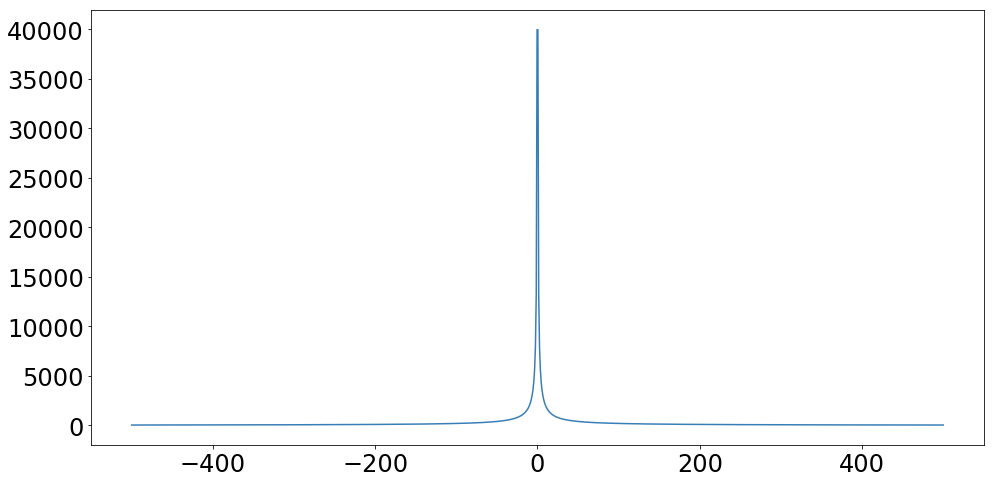

In [6]:
plt.plot(X,periods)
plt.show()

In [7]:
bandwidth = 120
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

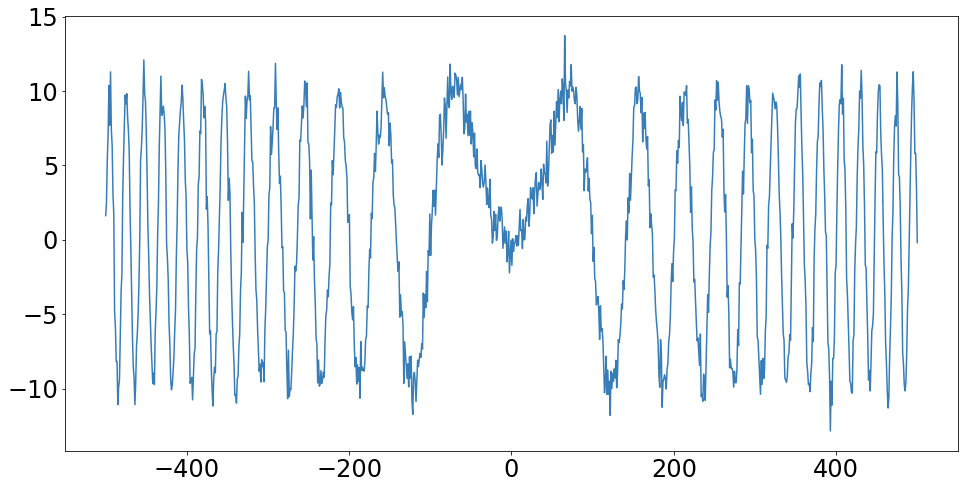

In [8]:
plt.plot(X,y)
plt.show()

In [9]:
kernel = np.sum((
    np.prod((
        gp.kernels.ConstantKernel(constant_value=5, constant_value_bounds=[1e-10,1e10]),
        gp.kernels.ExpSineSquared(length_scale=0.8, periodicity=50, length_scale_bounds="fixed", periodicity_bounds=[1,1e10])
    )),
    # The optimizer REEEAAALLLY wants to skip over periodicity=50 (which is the "true" periodicity....)
    gp.kernels.WhiteKernel(noise_level=10., noise_level_bounds="fixed")
))

In [10]:
print(
    kernel(np.array([[50]]), np.array([[50.0001]])),
    kernel(np.array([[50]]), np.array([[75]])),
    kernel(np.array([[50]]), np.array([[99]])),
    kernel(np.array([[50]]), np.array([[99.9999999]])),
    kernel(np.array([[50]]), np.array([[100]])),
)

[[5.]] [[0.21968467]] [[4.93877405]] [[5.]] [[5.]]


In [11]:
import importlib
import gpr_utils
importlib.reload(gpr_utils)
from gpr_utils import *
import gpr_utils
importlib.reload(gpr_utils)
from gpr_utils import *

In [12]:
exemplar_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)

In [15]:
center = bandwidth+1
#center = 2*bandwidth + 1
exemplar_rng = (center - bandwidth - 1, center + bandwidth - 2)
exemplar_X = X[slice(*exemplar_rng)]
exemplar_y = y[slice(*exemplar_rng)]
exemplar_regressor.fit(
    exemplar_X, 
    exemplar_y, 
    sample_weight = lm_kernel(np.abs(exemplar_X - np.mean(exemplar_X)))[:,0])

GPR(alpha=0, copy_X_train=True,
    kernel=2.24**2 * ExpSineSquared(length_scale=0.8, periodicity=50) + WhiteKernel(noise_level=10),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

In [16]:
np.exp(exemplar_regressor.kernel_.theta)

array([ 5.92890004, 26.24377075])

In [17]:
print(
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[50.0001]])),
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[50+np.exp(exemplar_regressor.kernel_.theta[0])]])),
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[50+2*np.exp(exemplar_regressor.kernel_.theta[0])]])),
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[75]])),
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[99]])),
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[99.9999999]])),
    exemplar_regressor.kernel_(np.array([[50]]), np.array([[100]])),
)

[[5.92890004]] [[1.57283057]] [[0.27966883]] [[5.53490202]] [[3.54693483]] [[4.53049829]] [[4.53049838]]


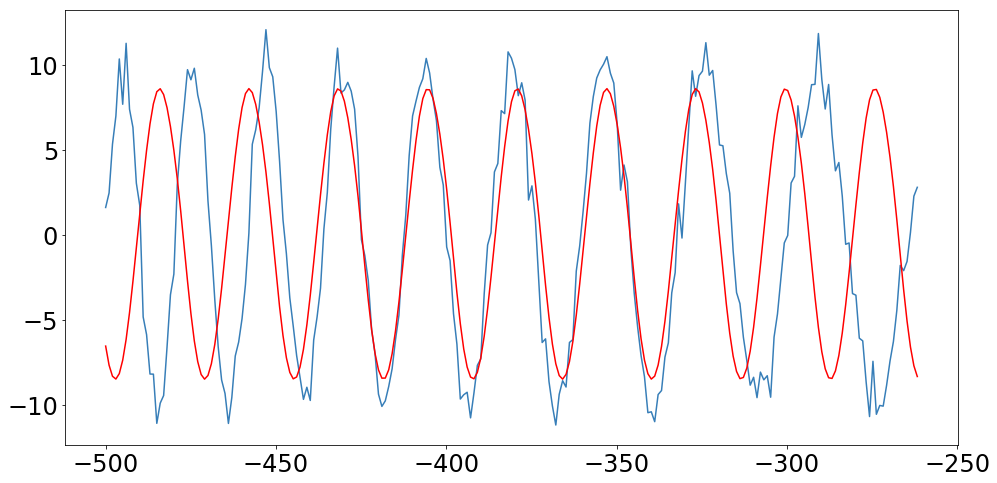

In [18]:
plt.plot(exemplar_X,exemplar_y)
plt.plot(exemplar_X,exemplar_regressor.predict(exemplar_X),c='r')
plt.savefig(os.path.join(project_dir, "exemplar_variable_period_b{:07.02f}_rng{}.png".format(bandwidth, str(exemplar_rng))))

In [19]:
cvs = [np.exp(exemplar_regressor.kernel_.theta[0])]
rbfs = [0.8]
wns = [10]
pds = [np.exp(exemplar_regressor.kernel_.theta[1])]

In [20]:
len(cvs)*len(rbfs), len(cvs)*len(rbfs)*len(wns)*len(pds), len(rbfs)*len(wns)*len(pds)

(1, 1, 1)

In [25]:
for cv, rbf, wn, pd in itertools.product(
    cvs,
    rbfs,
    wns,
    pds,
    ):
    try:
        kernel = np.sum((
            np.prod((
                gp.kernels.ConstantKernel(constant_value=cv, constant_value_bounds=[cv/10,cv*10]),
                gp.kernels.ExpSineSquared(length_scale=rbf, periodicity=pd, length_scale_bounds="fixed", periodicity_bounds=[pd/10,pd*10])
            )),
            # The optimizer REEEAAALLLY wants to skip over periodicity=50 (which is the "true" periodicity....)
            gp.kernels.WhiteKernel(noise_level=wn, noise_level_bounds="fixed")
        ))
        regressor = GPR(kernel=kernel, normalize_y=False, n_restarts_optimizer=0, alpha=0)
        gpr_models = local_models.local_models.LocalModels(regressor)

        print(rbf, pd, wn)
        gpr_models.fit(X, y, index=index)
        transformer_X = np.linspace(np.min(X), np.max(X), 1000).reshape(-1,1)
        gpr_params = gpr_models.transform(transformer_X,
            r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
            neighbor_beta0s=True, batch_size=int(transformer_X.shape[0]/10))
        filename = os.path.join(project_dir, "c{:10.02f}_r{:05.02f}_w{:05.02f}_p{:05.02f}_k{}.png".format(kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, kernel.k2.noise_level, kernel.k1.k2.periodicity, lm_kernel))
        plt_gpr_params(X/HZ, y, 
            transformer_X/HZ, np.exp(gpr_params),
            chg_ptses=[change_points/HZ],
            filename=filename, kernel=kernel, display=True)
    except Exception as e:
        print(e)
        print("failed!")
        logger.info("contrived period failed at c{:10.02f}_r{:05.02f}_w{:05.02f}_p{:05.02f}_k{}.png".format(kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, kernel.k2.noise_level, kernel.k1.k2.periodicity, lm_kernel))

0.8 26.243770754594745 10
unsupported operand type(s) for /: 'list' and 'int'
failed!


In [26]:
np.exp(np.max(gpr_params[:,1]))

168.23950504956596

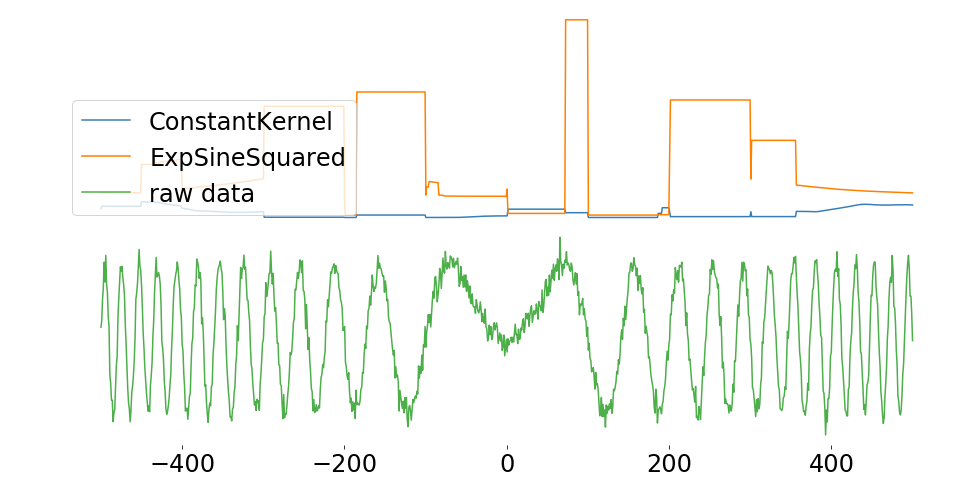

In [27]:
plt_gpr_params(X/HZ, y, 
    transformer_X/HZ, np.exp(gpr_params),
    chg_ptses=[np.array(change_points)/HZ],
    filename=None, kernel=kernel, display=True)

In [28]:
filename = os.path.join(project_dir, "c{:10.02f}_r{:05.02f}_w{:05.02f}_p{:05.02f}_k{}.dat".format(kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, kernel.k2.noise_level, kernel.k1.k2.periodicity, lm_kernel))
np.savetxt(filename, gpr_params)

In [29]:
ma_models = local_models.local_models.LocalModels(local_models.TLS_models.Mean())

In [30]:
help(ma_models.fit)

Help on method fit in module local_models.local_models:

fit(model_features, model_targets=None, model_cluster_features=None, sample_weight=None, index=None, ball_tree_kwargs={}) method of local_models.local_models.LocalModels instance



In [31]:
ma_models.fit(np.exp(gpr_params), model_cluster_features = X)

In [32]:
ma_kernel = local_models.local_models.TriCubeKernel(100)
smoothed_gpr_params = ma_models.transform(X, r=ma_kernel.support_radius(), kernel=ma_kernel)

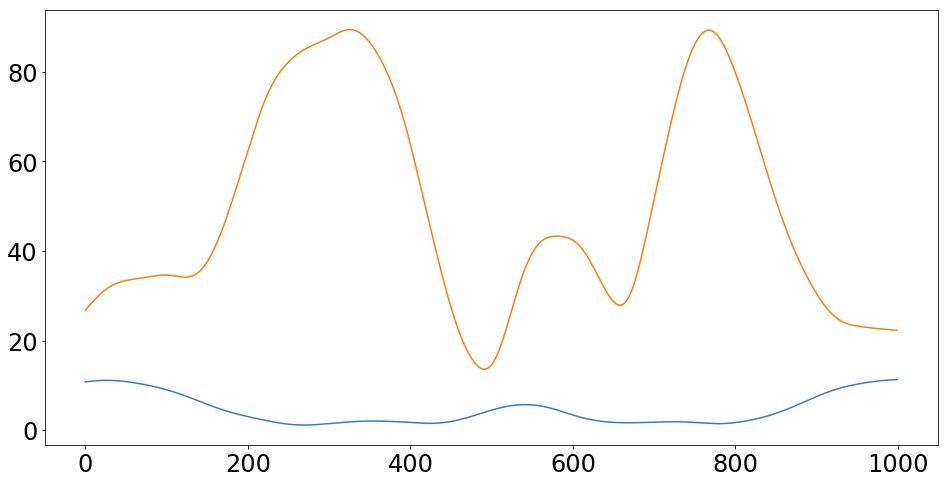

In [33]:
plt.plot(smoothed_gpr_params)

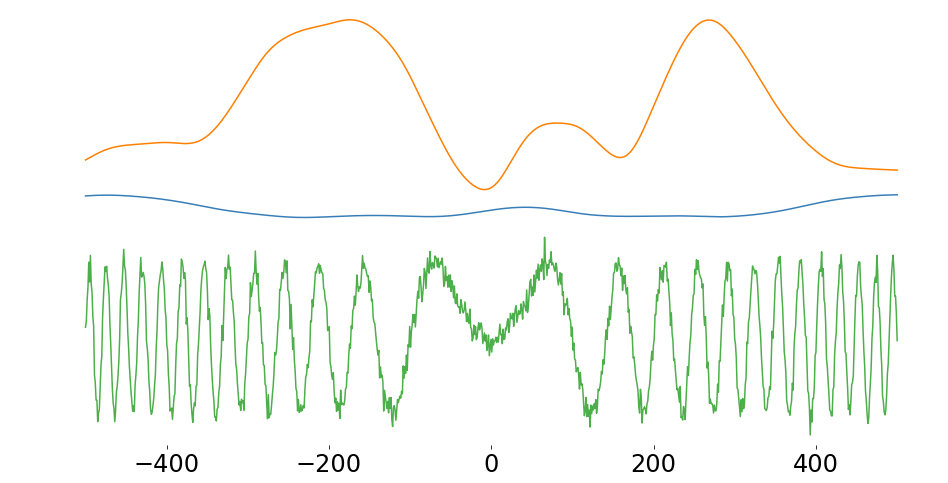

In [34]:
filename = os.path.join(project_dir, "c{:10.02f}_r{:05.02f}_w{:05.02f}_p{:05.02f}_k{}_smoothed{}.png".format(kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, kernel.k2.noise_level, kernel.k1.k2.periodicity, lm_kernel, ma_kernel))
plt_gpr_params(X/HZ, y,
    X/HZ, smoothed_gpr_params,
    chg_ptses=[np.array(change_points)/HZ],
    filename=filename, kernel=kernel, display=True, legend=False)

In [ ]:
np.argmin(gpr_params[:,1])

In [ ]:
gpr_params[285,1]

In [ ]:
np.mean(next(gpr_models._batch_query(np.array([[285]]), r = lm_kernel.support_radius()-1, kernel=lm_kernel))[1])

In [ ]:
next(gpr_models._batch_query(np.array([[-500+285]]), r = lm_kernel.support_radius()-1, kernel=lm_kernel))[1]

In [ ]:
vals = np.exp(np.random.uniform(np.log(1e-10), np.log(1e10),10000))

In [ ]:
whats = []
for i, val in enumerate(vals):
    if not i%10:
        print(i)
    ernel = np.sum((
        np.prod((
            gp.kernels.ConstantKernel(constant_value=5, constant_value_bounds="fixed"),
            gp.kernels.ExpSineSquared(length_scale=0.8, periodicity=val, length_scale_bounds="fixed", periodicity_bounds=[1e-10,1e10])
        )),
        # The optimizer REEEAAALLLY wants to skip over periodicity=50 (which is the "true" periodicity....)
        gp.kernels.WhiteKernel(noise_level=10., noise_level_bounds="fixed")
    ))
    agressor = GPR(kernel=ernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)

    agressor.kernel_ = ernel
    agressor.X_train_ = exemplar_X
    weights = lm_kernel(np.abs(exemplar_X - np.mean(exemplar_X)))[:,0]
    weights /= np.sum(weights)
    weights *= len(weights)
    agressor.sample_weight_train_ = weights
    agressor.y_train_ = exemplar_y
    what = agressor.log_marginal_likelihood(ernel.theta)
    if what != -np.inf:
        print(what)
    whats.append((val,what))

In [ ]:
plt.plot(np.array(whats)[:,0], np.array(whats)[:,1])